# Titanic Survival Prediction Using Random Forest

I chose Random Forest because it handles both numeric and categorical features, handles missing or messy data, reduces overfitting compared to a single tree, and provides feature importance to understand which factors affected survival.


## 1- As always, first step is importing and loading the dataset...

In [8]:
# Libs for data manipulation
import pandas as pd
import numpy as np

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt

# Machine learning
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier # The Random Forest
from sklearn.metrics import classification_report, accuracy_score

# Load Titanic dataset from seaborn
titanic = sns.load_dataset("titanic")
titanic.head()

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,NaN,Southampton,no,False
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,NaN,Southampton,yes,True
3,1,1,female,35.0,1,0,53.1000,S,First,woman,False,C,Southampton,yes,False
4,0,3,male,35.0,0,0,8.0500,S,Third,man,True,NaN,Southampton,no,True


-
-


## 2- Exploring and cleaning...

We need to know which features have missing values, because most ML models (including Random Forest) cannot handle NaNs.

In [9]:
# check missing values
print(titanic.isnull().sum())


survived         0
pclass           0
sex              0
age            177
sibsp            0
parch            0
fare             0
embarked         2
class            0
who              0
adult_male       0
deck           688
embark_town      2
alive            0
alone            0
dtype: int64


from the data exploration, we find that:
- `deck` has a lot of missing values → too much cleaning effort for now.
- `embark_town` is redundant with `embarked` (both indicate port).
- `alive` is the same as `survived` → duplicate target.

Dropping these simplifies the dataset and avoids confusion.


In [10]:
titanic = titanic.drop(columns=['deck', 'embark_town', 'alive'])


also..
- `age` has some missing values.

Using .median() is simple and robust → replaces missing ages with a “typical” age.

This **avoids dropping too many rows**, which could reduce your dataset size.

In [11]:
titanic['age'] = titanic['age'].fillna(titanic['age'].median()) #instead of dropping 177 records


`embarked` only has a few missing values, so its easier to drop these rows than fill them, keeping the dataset clean without making assumptions.

In [12]:
titanic = titanic.dropna(subset=['embarked'])


After cleaning, we encode because Random Forests (and most ML models) cannot handle text labels, only numbers.


In [13]:
# Encode categorical variables
le = LabelEncoder()
for col in ['sex', 'class', 'who', 'alone', 'embarked', 'adult_male']:
    titanic[col] = le.fit_transform(titanic[col])

finally we choose the features and the target.


In [14]:
# Select features and target
X = titanic.drop(columns=['survived', 'who', 'adult_male'])  # drop extra non-important columns
y = titanic['survived'] # we want the moldel to figure this out - model output.

we drop more features to simplify the model, this time these features are informative but redundant:
- `survived` is what we want to predict
- `who` basically contains info already in `sex` and `age`
- `adult_male` also derived from `sex` + `age`

-
-


## 3- Data Splitting

80% training data    
20% testing data

In [15]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

-
-

## 4- Train a Random Forest


In [16]:
# Create the RF object
rf = RandomForestClassifier(random_state=42) # 'random_state=42' ensures reproducibility

#no training done at this point, the obj is just created.

rf.fit(X_train, y_train) # now the training takes place. .fit() is where the learning happens

y_pred = rf.predict(X_test) # predicitons are made
# Takes new, unseen data (X_test) and asks each tree for its prediction.
# Each tree votes, and the majority vote wins → this is the predicted class for each passenger.


# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy: 0.8089887640449438
              precision    recall  f1-score   support

           0       0.84      0.85      0.85       110
           1       0.76      0.74      0.75        68

    accuracy                           0.81       178
   macro avg       0.80      0.79      0.80       178
weighted avg       0.81      0.81      0.81       178



The model correctly predicted survival for `~81%` of passengers on the test set.


 Class 0 (Did not survive)

- Precision = 0.84 → Of all passengers predicted as “did not survive,” 84% were actually correct.

- Recall = 0.85 → Of all passengers who actually did not survive, 85% were correctly identified.

Class 1 (Survived)

- Precision = 0.76 → Of all passengers predicted as “survived,” 76% were correct.

- Recall = 0.74 → Of all passengers who actually survived, 74% were correctly identified.


_Survived passengers are slightly harder to predict, which makes sense because the dataset is slightly imbalanced (more didn’t survive)._

-
-

## 5- Feature Importance

the measure of the impact each input variable (feature) has on the output of a predictive model

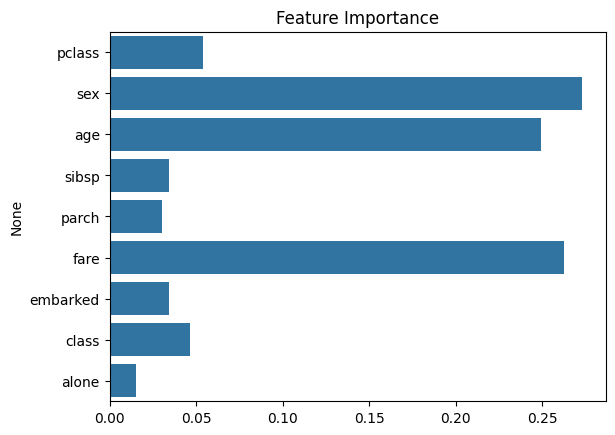

In [17]:
# Visualize which features mattered most
importances = rf.feature_importances_
features = X.columns
sns.barplot(x=importances, y=features)
plt.title("Feature Importance")
plt.show()


-
-
-


## Hyperparameter Tuning

In [20]:
param_grid = {
    'n_estimators': [50, 100, 200], #num of trees
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5, 10]
}

grid = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, cv=5)
grid.fit(X_train, y_train)

print("Best params:", grid.best_params_)

# Evaluate best model
best_rf = grid.best_estimator_
y_pred_best = best_rf.predict(X_test)
print("Accuracy after tuning:", accuracy_score(y_test, y_pred_best))


Best params: {'max_depth': 10, 'min_samples_split': 10, 'n_estimators': 200}
Accuracy after tuning: 0.8033707865168539


_Hyperparameter tuning slightly reduced test accuracy but improved model robustness and generalization by preventing overfitting._